- https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB
-  

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from ML_loader import DatasetLoader,ModelLoader


In [2]:
#Get data 
loader = DatasetLoader()
#loader.read_dataset('./partial_database.csv',class_path='labelsDefault.txt',separator=',')
#loader.read_dataset('./features_resnet.csv',class_path='labelsDefault.txt',separator=',')
#loader.read_dataset('./features_googlenet.csv',class_path='labelsDefault.txt',separator=',')
loader.read_dataset('./features_mobilenet_large_no_norm.csv',class_path='labelsDefault.txt',separator=',')

loader.X=loader.normalize_features([0,loader.df.shape[1]],"MinMaxScaler")

#loader.add_dataset(file_path='./features_googlenet.csv')
#loader.add_dataset(file_path='./features_mobilenet.csv')
loader.add_dataset(file_path='./partial_database.csv')
   

loader.split_dataset()
#Normalize data, if not already normalized
print(np.shape(loader.X_train),np.shape(loader.X_test),np.shape(loader.y_train),np.shape(loader.y_test))

(4048, 977) (1012, 977) (4048,) (1012,)


In [3]:
#Get model
model = ModelLoader()
model.set_model(MultinomialNB())

cv = RepeatedStratifiedKFold(n_splits=22, n_repeats=3, random_state=1)

#Optimization 
param = {'alpha': np.linspace(0.5, 1.5, 6),
            'fit_prior': [True, False]}

model.set_optimal_params(param)
model.optimize(loader.X_train,loader.y_train,cv=cv,scoring='accuracy',n_iter=10)

#Train model with optimal params
model.set_model(MultinomialNB(**model.optimal_params))

In [4]:
print(model.optimal_params)

{'fit_prior': True, 'alpha': 0.5}


Partial fit
[3 6 4 1 7 2 5]
Score accuracy group 0:  0.7204968944099379
Score accuracy group learned 0:  0.7204968944099379
Score accuracy global:  0.24110671936758893
Memory:  330.27734375 MB
Partial fit
[8]
Score accuracy group 1:  0.6304347826086957
Score accuracy group learned 0:  0.7142857142857143
Score accuracy group learned 1:  0.6304347826086957
Score accuracy global:  0.26976284584980237
Memory:  338.21875 MB
Partial fit
[9]
Score accuracy group 2:  0.9130434782608695
Score accuracy group learned 0:  0.6925465838509317
Score accuracy group learned 1:  0.6304347826086957
Score accuracy group learned 2:  0.9130434782608695
Score accuracy global:  0.31719367588932806
Memory:  344.3815104166667 MB
Partial fit
[10]
Score accuracy group 3:  0.5
Score accuracy group learned 0:  0.6925465838509317
Score accuracy group learned 1:  0.6304347826086957
Score accuracy group learned 2:  0.9130434782608695
Score accuracy group learned 3:  0.5
Score accuracy global:  0.33695652173913043
Memo

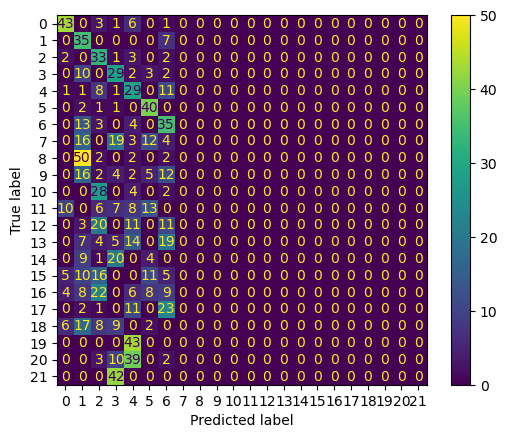

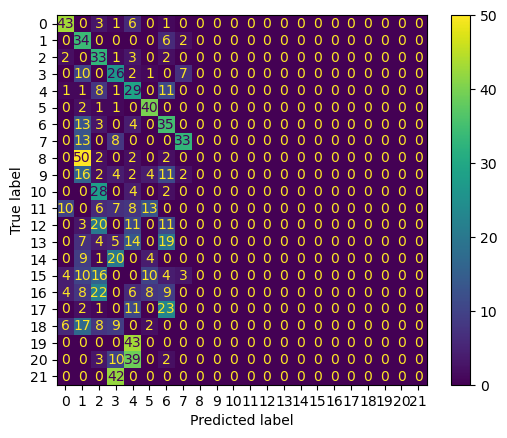

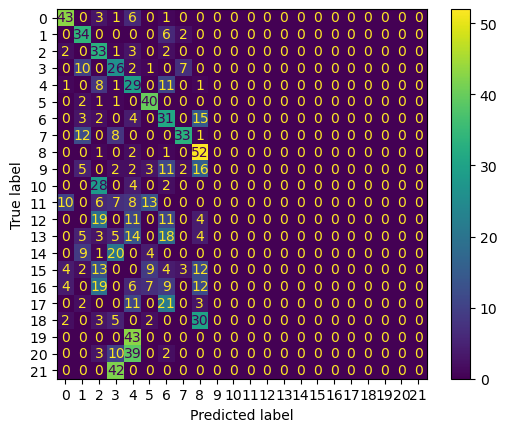

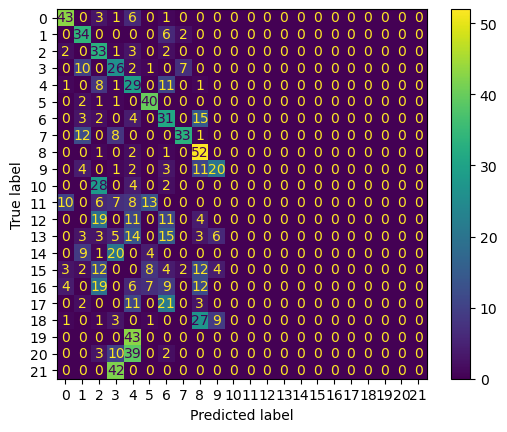

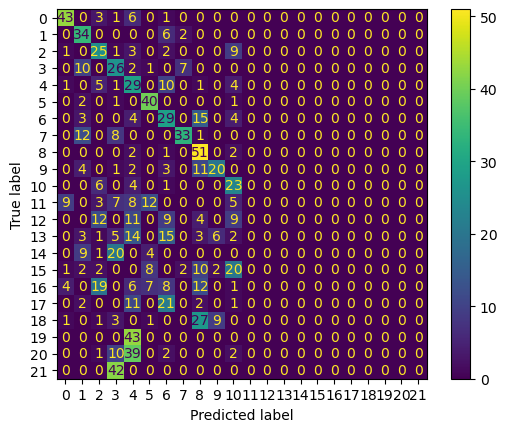

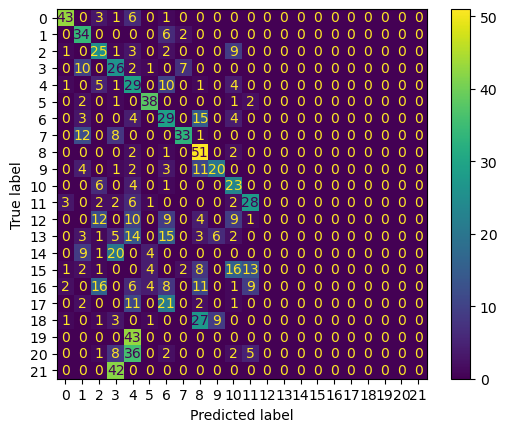

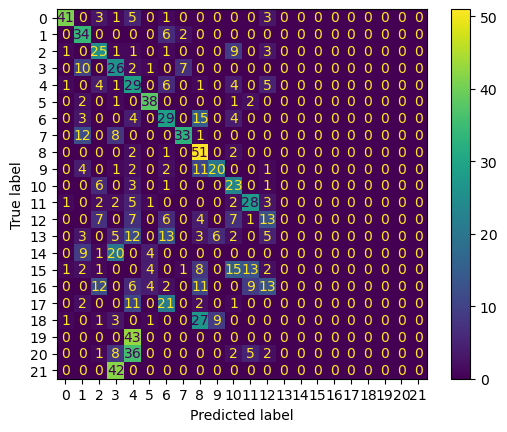

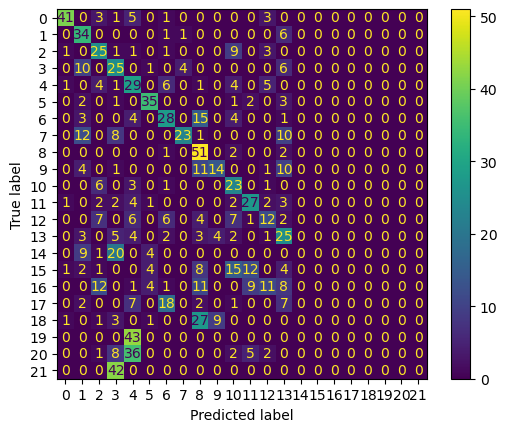

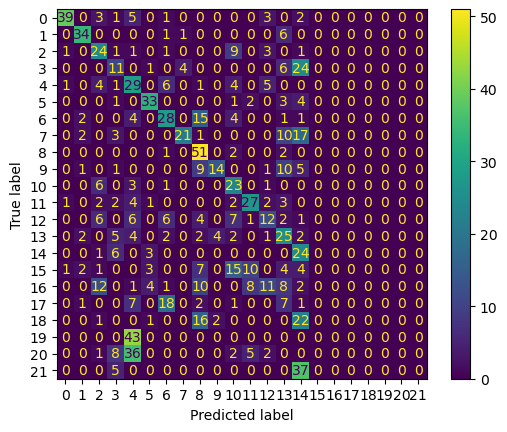

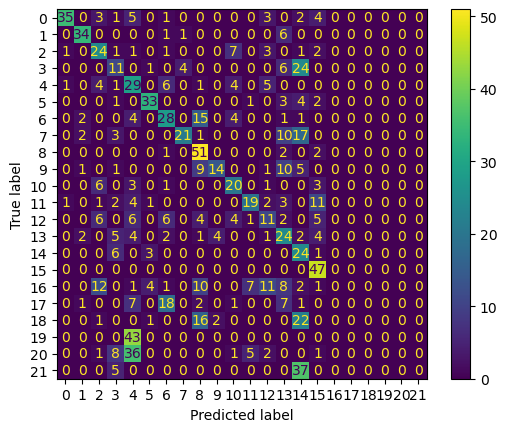

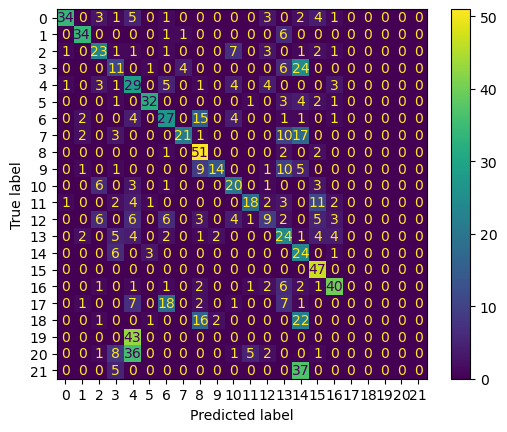

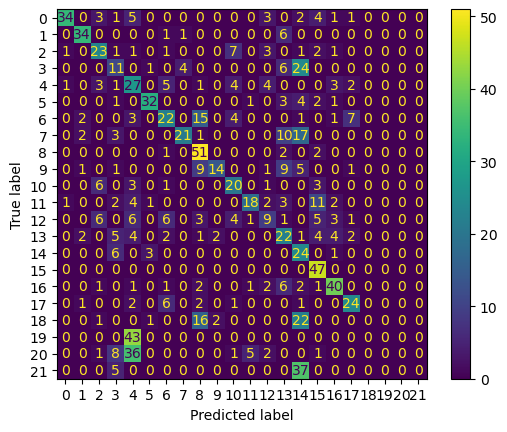

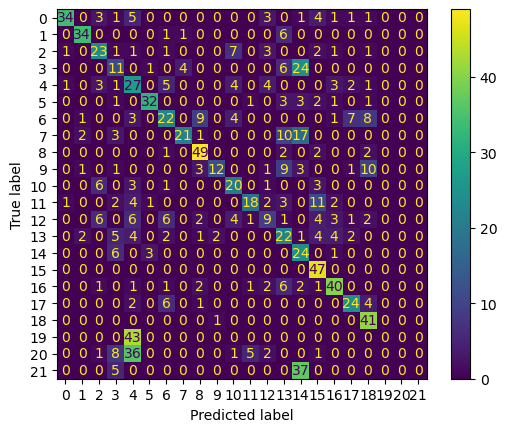

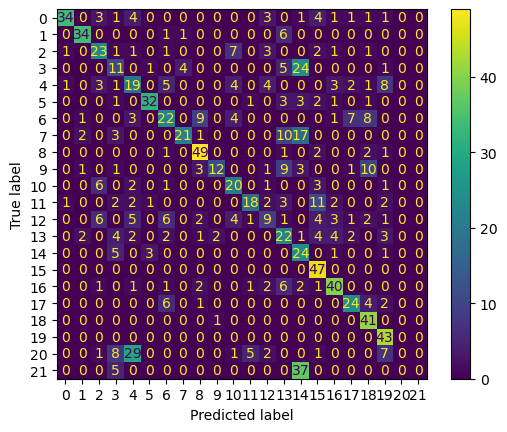

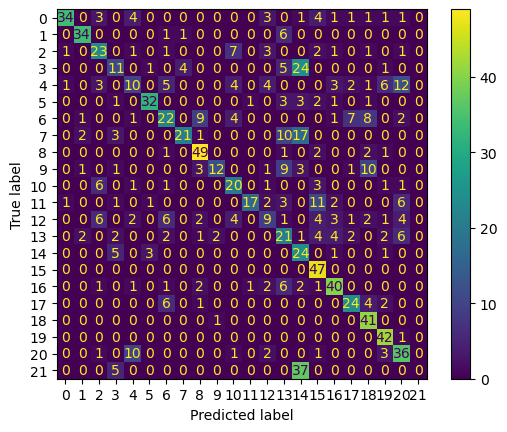

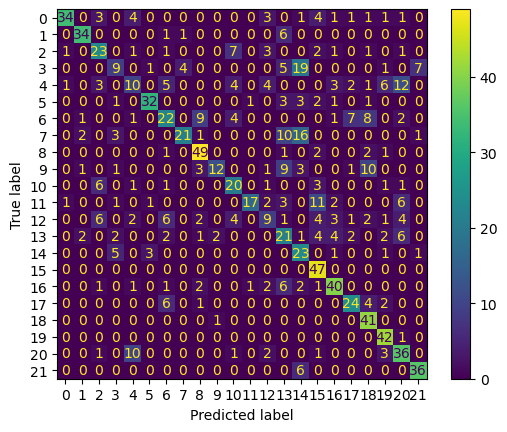

In [5]:
##Split by class, to increment by class:
#class_to_group = {1:[1,2,3,4,5,6,7],2:[8,9],3:[10,11,12,13],4:[14,15,16],5:[17,18],6:[19],7:[20,21,22]}
class_to_group = {1:[1,2,3,4,5,6,7], 2:[8], 3:[9], 4:[10], 5:[11], 6:[12], 7:[13], 8:[14], 9:[15], 10:[16], 11:[17], 12:[18], 13:[19], 14:[20], 15:[21], 16:[22]}

X_train_merged, X_test_merged, y_train_merged, y_test_merged=loader.split_dataset_class(class_to_group,random_state=1)
memory_values = []
accuracy_learned_grouped = []


#Train model
for idx,(X_train,y_train,X_test,y_test) in enumerate(zip(X_train_merged,y_train_merged,X_test_merged,y_test_merged)):
    mem,res=model.partial_fit_train(X_train,y_train,classes=loader.classes)
    print(y_train.unique())
    print(f"Score accuracy group {idx}: ",model.score(X_test,y_test))
    accuracy_learned = []
    for i in range(idx+1):
        print(f"Score accuracy group learned {i}: ",model.score(X_test_merged[i],y_test_merged[i]))
        accuracy_learned.append(model.score(X_test_merged[i],y_test_merged[i]))
    print("Score accuracy global: ",model.score(loader.X_test,loader.y_test))
    print("Memory: ",np.mean(mem),"MB")
    memory_values.append(np.mean(mem))
    accuracy_learned_grouped.append(accuracy_learned)
    y_pred=model.predict(loader.X_test)
    cm = confusion_matrix(loader.y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

model.reset_model()

average_memory = np.mean(memory_values)
print("Average memory usage: ", average_memory,"MB")

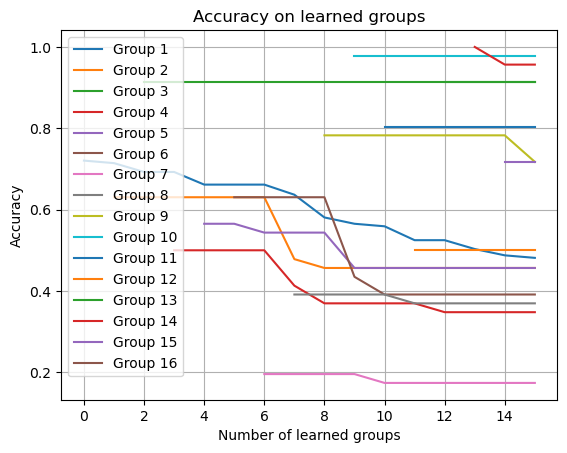

<Axes: title={'center': 'Accuracy on learned groups'}, xlabel='Number of learned groups', ylabel='Accuracy'>

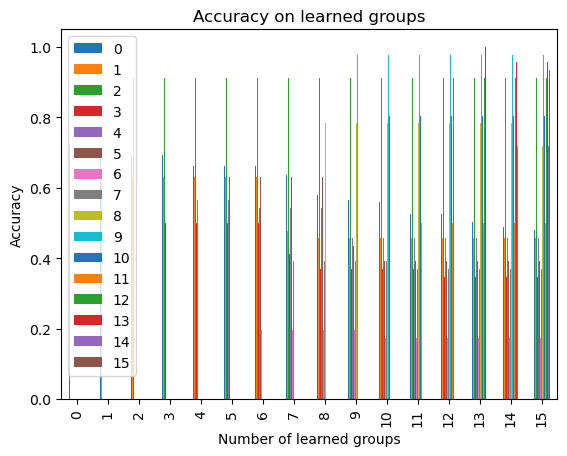

In [6]:
#Figure for accuracy on learned class and (todo:global)
df = pd.DataFrame(accuracy_learned_grouped)
df1 = df.replace(np.nan, 0)
df=df.T

fig, ax = plt.subplots()
for i in range(len(class_to_group)):
    ax.plot(list(df.iloc[i]),label=f'Group {i+1}')

ax.set(xlabel='Number of learned groups', ylabel='Accuracy',
        title='Accuracy on learned groups')

ax.grid()
ax.legend()
plt.show()

# Bar plot 
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set(xlabel='Number of learned groups', ylabel='Accuracy',
        title='Accuracy on learned groups')

df1.plot(kind='bar', ax=ax)

Partial fit
Score accuracy batch 0:  0.5790513833992095
Score accuracy global:  0.5938735177865613
Memory:  842.7494419642857 MB
Partial fit
Score accuracy batch 1:  0.6086956521739131
Score accuracy global:  0.5948616600790514
Memory:  848.3258928571429 MB
Partial fit
Score accuracy batch 2:  0.6482213438735178
Score accuracy global:  0.5968379446640316
Memory:  858.1025390625 MB
Partial fit
Score accuracy batch 3:  0.5830039525691699
Score accuracy global:  0.5978260869565217
Memory:  863.75048828125 MB
Partial fit
Score accuracy batch 4:  0.5869565217391305
Score accuracy global:  0.5988142292490118
Memory:  825.76025390625 MB
Partial fit
Score accuracy batch 5:  0.6067193675889329
Score accuracy global:  0.5978260869565217
Memory:  823.5407366071429 MB
Partial fit
Score accuracy batch 6:  0.5948616600790514
Score accuracy global:  0.5988142292490118
Memory:  827.4605034722222 MB
Partial fit
Score accuracy batch 7:  0.6047430830039525
Score accuracy global:  0.5978260869565217
Memor

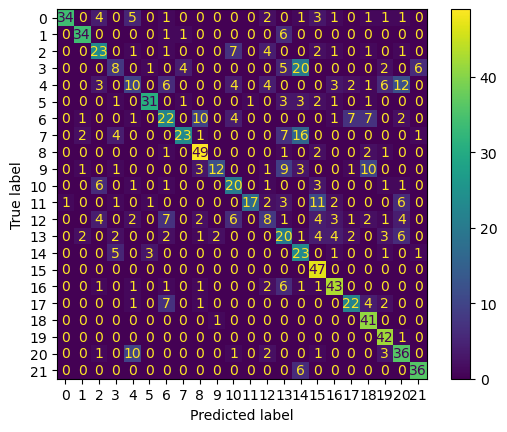

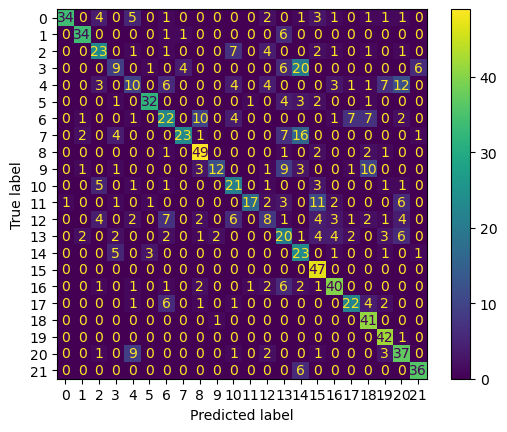

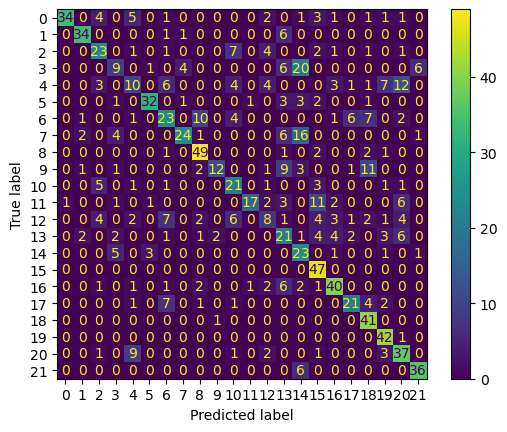

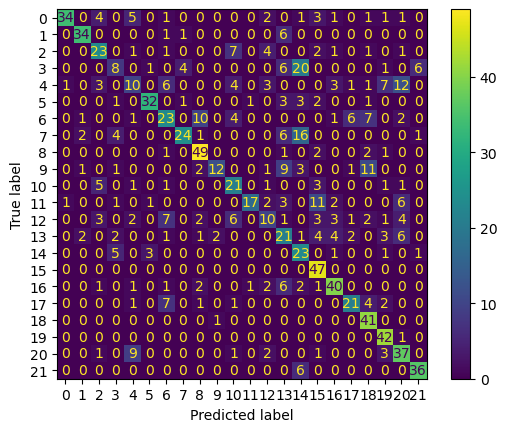

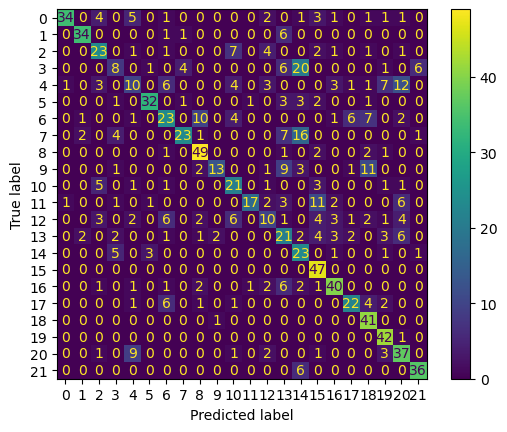

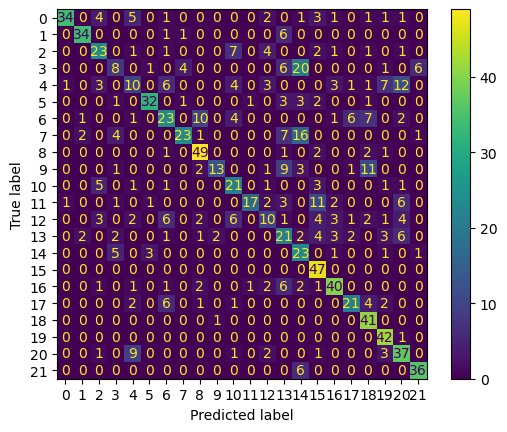

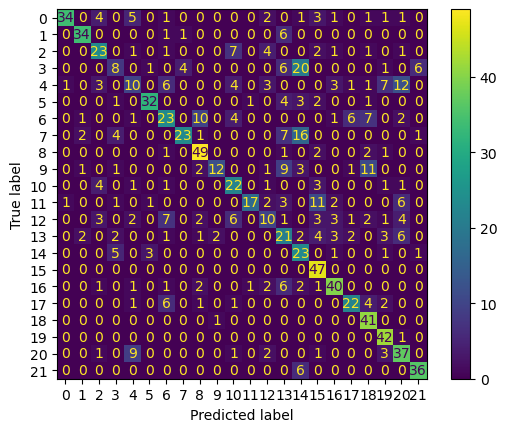

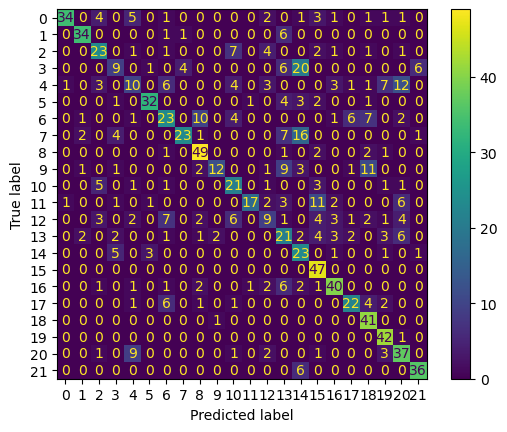

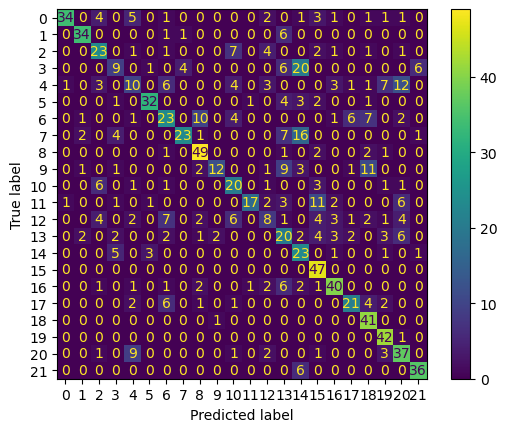

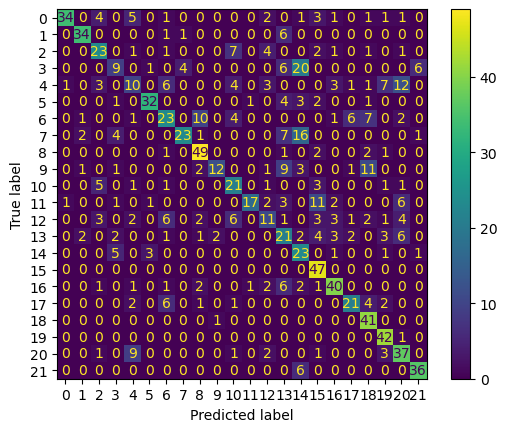

In [7]:
X_train_split_data,y_train_split_data,X_test_split_data,y_test_split_data=loader.split_dataset_data(10,random_state=1)
memory_values = []

for x in range(len(X_train_split_data)):
    mem,res=model.partial_fit_train(X_train_split_data[x],y_train_split_data[x],classes=loader.classes)
    print(f"Score accuracy batch {x}: ",model.score(X_test_split_data[x],y_test_split_data[x]))
    print("Score accuracy global: ",model.score(loader.X_test,loader.y_test))
    print("Memory: ",np.mean(mem),"MB")
    memory_values.append(np.mean(mem))

    y_pred=model.predict(loader.X_test)
    cm = confusion_matrix(loader.y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

model.reset_model()

average_memory = np.mean(memory_values)
print("Average memory usage: ", average_memory,"MB")